In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
gaap = pd.read_csv('../data/외감_1999_2023.csv')

In [3]:
# 라벨링을 위한 2024년 데이터 로드
gaap_label1 = pd.read_excel('../data/외감_2024_라벨1.xlsx')
gaap_label2 = pd.read_excel('../data/외감_2024_라벨2.xlsx')
gaap_label3 = pd.read_excel('../data/외감_2024_라벨3.xlsx')
gaap_label4 = pd.read_excel('../data/외감_2024_라벨4.xlsx')

gaap_label = pd.concat([gaap_label1, gaap_label2, gaap_label3, gaap_label4])

# 컬럼명 정리
gaap_label.columns = gaap_label.columns.str.replace('(*)', '')
gaap_label.columns = gaap_label.columns.str.replace('(천원)', '')

# 결측치 드랍
gaap_label = gaap_label.loc[gaap_label.isna().sum(axis=1) == 0, : ]

# 라벨용 파생변수 생성
gaap_label['이자보상배율'] = gaap_label['영업이익(손실)']/gaap_label['이자비용']
gaap_label['자본잠식률'] = (gaap_label['자본금'] - gaap_label['자본'])/gaap_label['자본금']

# 파생변수의 무한대 값과 nan 정리
for col in gaap_label.columns[-2 : ] :
    gaap_label.loc[gaap_label[col].isin([np.inf]), col] = gaap_label.loc[~gaap_label[col].isin([np.inf, -np.inf]), col].max()
    gaap_label.loc[gaap_label[col].isin([-np.inf]), col] = gaap_label.loc[~gaap_label[col].isin([np.inf, -np.inf]), col].min()

gaap_label[['이자보상배율', '자본잠식률']].fillna(0, inplace=True)

# 년도 컬럼 생성
gaap_label['년도'] = 2024

In [4]:
# 데이터 통합 후 정리
gaap = pd.concat([gaap, gaap_label])
gaap.sort_values(['거래소코드', '회계년도'], inplace=True)
gaap.reset_index(drop=True, inplace=True)

In [5]:
# 라벨링
gaap['label'] = ((gaap['이자보상배율'].shift(-1) < 1) | (gaap['자본잠식률'].shift(-1) >= 50)).astype(int)

# 다음해 데이터가 없는 경우 정상으로 분류
gaap.loc[gaap['거래소코드'] != gaap['거래소코드'].shift(-1), 'label'] = 0
gaap.loc[(gaap['년도'] + 1) != gaap['년도'].shift(-1), 'label' ] = 0

# 전 해 데이터가 없는데 이자보상배율이 1 미만이거나 자본잠식률이 50% 이상인 경우 부실로 분류
flag1 = (gaap['거래소코드'] != gaap['거래소코드'].shift()) | ((gaap['년도'] - 1) != gaap['년도'].shift())
flag2 = (gaap['이자보상배율'] < 1) | (gaap['자본잠식률'] >= 50)
gaap.loc[flag1 & flag2, 'label'] = 1

In [6]:
# 라벨 확인
gaap.loc[ : 20, ['회사명', '회계년도', '이자보상배율', '자본잠식률', 'label']]

,회사명,회계년도,이자보상배율,자본잠식률,label
0,(주)포스코이앤씨,1999/12,4.453730,-79.821927,0
1,(주)포스코이앤씨,2000/12,1.989666,-79.821927,0
2,(주)포스코이앤씨,2001/12,7.448537,-79.821927,0
3,(주)포스코이앤씨,2008/12,1.954649,-199.718223,0
4,(주)포스코이앤씨,2009/12,1.954649,-199.718223,0
5,(주)포스코이앤씨,2010/12,1.954649,-178.775014,0
6,(주)포스코이앤씨,2011/12,1.954649,-178.775014,0
7,(주)포스코이앤씨,2013/12,2.060813,-178.775014,0
8,(주)포스코이앤씨,2014/12,1.954649,-178.775014,0
9,(주)포스코이앤씨,2015/12,2.849429,-291.719987,1


In [7]:
# 한번 부실 징후가 나타난 기업은 이후 데이터 삭제
gaap['target'] = np.nan
gaap.loc[gaap['거래소코드'] != gaap['거래소코드'].shift(), 'target'] = 0
gaap.loc[(gaap['label'].shift() == 1) & (gaap['거래소코드'] == gaap['거래소코드'].shift()), 'target'] = '삭제'
gaap['target'].fillna(method = 'ffill', inplace=True)

In [8]:
# 타겟 확인
gaap.loc[ : 20, ['회사명', '회계년도', 'label', 'target']]

,회사명,회계년도,label,target
0,(주)포스코이앤씨,1999/12,0,0.0
1,(주)포스코이앤씨,2000/12,0,0.0
2,(주)포스코이앤씨,2001/12,0,0.0
3,(주)포스코이앤씨,2008/12,0,0.0
4,(주)포스코이앤씨,2009/12,0,0.0
5,(주)포스코이앤씨,2010/12,0,0.0
6,(주)포스코이앤씨,2011/12,0,0.0
7,(주)포스코이앤씨,2013/12,0,0.0
8,(주)포스코이앤씨,2014/12,0,0.0
9,(주)포스코이앤씨,2015/12,1,0.0


In [9]:
# 부실 징후가 나타난 기업의 이후 데이터 삭제
gaap = gaap.loc[gaap['target'] != '삭제' , : ]

In [10]:
# 1999년, 2024년 데이터 삭제
gaap = gaap.loc[~gaap['년도'].isin([1999, 2024]), : ]

In [11]:
# 상장 데이터와 겹치는 기업 삭제
market = pd.read_excel('../data/상장_gaap_ifrs_ratios(1999-2023).xlsx')
gaap = gaap.loc[~gaap['거래소코드'].isin([market['거래소코드'].unique()]), : ]

In [12]:
# 불필요한 컬럼 삭제
gaap.drop(['년도', 'target'], axis=1, inplace=True)

In [13]:
# 인덱스 리셋
gaap.reset_index(drop=True, inplace=True)

In [14]:
# 데이터 확인
gaap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143332 entries, 0 to 143331
Data columns (total 77 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   회사명                    143332 non-null  object 
 1   거래소코드                  143332 non-null  int64  
 2   회계년도                   143332 non-null  object 
 3   산업코드                   143332 non-null  float64
 4   산업명                    143332 non-null  object 
 5   종업원                    143332 non-null  float64
 6   자산                     143332 non-null  float64
 7   유동자산                   143332 non-null  float64
 8   비유동자산                  143332 non-null  float64
 9   유형자산                   143332 non-null  float64
 10  재고자산                   143332 non-null  float64
 11  매출채권                   143332 non-null  float64
 12  자본                     143332 non-null  float64
 13  자본금                    143332 non-null  float64
 14  자본잉여금                  143332 non-nu

In [15]:
# 개수 확인
print(f"총 인덱스 수 : {len(gaap)}")
print(f"부실 징후 인덱스 수 : {(gaap['label'] == 1).sum()}")
print(f"정상 인덱스 수 : {(gaap['label'] == 0).sum()}")
print(f"총 기업 수 : {len(gaap['거래소코드'].unique())}")
print(f"부실 징후 기업 수 : {len(gaap.loc[gaap['label'] == 1, '거래소코드'].unique())}")
print(f"정상 기업 수 : {len(gaap.loc[gaap['label'] == 0, '거래소코드'].unique())}")

총 인덱스 수 : 143332
부실 징후 인덱스 수 : 48762
정상 인덱스 수 : 94570
총 기업 수 : 61643
부실 징후 기업 수 : 48762
정상 기업 수 : 24462


In [16]:
gaap.loc[ : 20, ['회사명', '회계년도', 'label']]

,회사명,회계년도,label
0,(주)포스코이앤씨,2000/12,0
1,(주)포스코이앤씨,2001/12,0
2,(주)포스코이앤씨,2008/12,0
3,(주)포스코이앤씨,2009/12,0
4,(주)포스코이앤씨,2010/12,0
5,(주)포스코이앤씨,2011/12,0
6,(주)포스코이앤씨,2013/12,0
7,(주)포스코이앤씨,2014/12,0
8,(주)포스코이앤씨,2015/12,1
9,국제종합기계(주),2000/12,0


In [17]:
# 데이터 저장
gaap.to_csv('../data/외감_all_label.csv', index=False)

In [18]:
# 라벨별 데이터 확인
gaap_1 = gaap.loc[gaap['label'] == 1, : ]
gaap_0 = gaap.loc[gaap['label'] == 0, : ]

In [19]:
gaap_1.describe()

,거래소코드,산업코드,종업원,자산,유동자산,비유동자산,유형자산,재고자산,매출채권,자본,...,DSRI,GMI,AQI,SGI,DEPI,SGAI,LVGI,TATA,Beneish M-Score,label
count,48762.000000,48762.000000,48762.000000,4.876200e+04,4.876200e+04,4.876200e+04,4.876200e+04,4.876200e+04,4.876200e+04,4.876200e+04,...,4.876200e+04,48762.000000,4.876200e+04,48762.000000,48762.000000,48762.000000,48762.000000,48762.000000,4.876200e+04,48762.0
mean,70043.334502,81001.545978,33.514684,3.231401e+10,1.578449e+10,1.616497e+10,1.099125e+10,7.027232e+09,2.846293e+09,7.200883e+09,...,4.176180e+04,0.217222,1.047597e+05,0.266399,0.245577,0.338068,0.211291,0.070490,8.073952e+04,1.0
std,27447.805999,44559.228109,163.056463,7.897106e+10,3.514228e+10,5.483832e+10,3.548524e+10,1.897411e+10,9.998161e+09,3.247664e+10,...,8.237688e+05,0.492869,4.408974e+06,1.872271,4.048762,15.467536,0.416294,0.386105,1.968648e+06,0.0
min,10000.000000,10100.000000,0.000000,2.946909e+09,2.101385e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.297218e+10,...,0.000000e+00,0.000000,-2.415948e+08,0.000000,0.000000,0.000000,0.000000,-31.484222,-9.760432e+07,1.0
25%,49167.250000,32900.000000,0.000000,1.073288e+10,2.625616e+09,1.324041e+09,7.218075e+07,0.000000e+00,0.000000e+00,-4.335725e+07,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-0.059563,-5.004713e+00,1.0
50%,70281.000000,74604.000000,2.000000,1.528911e+10,7.113322e+09,6.977712e+09,4.416860e+09,9.514505e+08,4.197475e+08,1.837513e+09,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.001202,-4.604592e+00,1.0
75%,92997.750000,126801.000000,25.000000,2.644795e+10,1.497380e+10,1.314434e+10,1.033347e+10,6.131593e+09,2.400576e+09,5.780680e+09,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.123030,-2.609686e+00,1.0
max,116714.000000,209801.000000,12349.000000,1.232728e+12,4.700015e+11,8.992078e+11,6.471876e+11,2.193083e+11,1.622124e+11,5.310694e+11,...,1.629086e+07,41.462320,1.325706e+08,339.485714,708.566662,3216.543489,4.812395,3.625557,6.854612e+07,1.0


In [20]:
gaap_0.describe()

,거래소코드,산업코드,종업원,자산,유동자산,비유동자산,유형자산,재고자산,매출채권,자본,...,DSRI,GMI,AQI,SGI,DEPI,SGAI,LVGI,TATA,Beneish M-Score,label
count,94570.000000,94570.000000,94570.000000,9.457000e+04,9.457000e+04,9.457000e+04,9.457000e+04,9.457000e+04,9.457000e+04,9.457000e+04,...,9.457000e+04,94570.000000,9.457000e+04,94570.000000,94570.000000,94570.000000,94570.000000,94570.000000,9.457000e+04,94570.0
mean,58247.283673,58286.288104,95.528836,4.596436e+10,2.083743e+10,2.485008e+10,1.609003e+10,5.609283e+09,7.895661e+09,2.012878e+10,...,9.319609e+04,0.747075,2.136453e+05,0.983232,1.196087,0.855889,0.702025,0.003251,1.720493e+05,0.0
std,27655.568632,35184.633511,428.075167,1.183738e+11,4.673046e+10,8.001252e+10,4.895873e+10,1.686810e+10,1.706823e+10,5.299137e+10,...,1.228634e+06,0.647469,9.148782e+06,11.783822,83.935493,22.956858,0.463108,0.153084,3.904694e+06,0.0
min,10000.000000,10100.000000,0.000000,2.946909e+09,2.101385e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+06,...,0.000000e+00,0.000000,-2.415948e+08,0.000000,0.000000,0.000000,0.000000,-6.726801,-9.760432e+07,0.0
25%,40317.000000,32403.000000,2.000000,1.307860e+10,5.332924e+09,5.024234e+09,2.839118e+09,2.474715e+08,1.393325e+09,3.849730e+09,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-0.057287,-4.044842e+00,0.0
50%,59196.000000,33003.000000,33.000000,1.908278e+10,9.614046e+09,9.130406e+09,6.841220e+09,1.575572e+09,3.359605e+09,7.637869e+09,...,8.520404e-01,0.928432,8.712406e-01,0.995014,0.888552,0.920651,0.924211,-0.007151,-2.631358e+00,0.0
75%,78745.500000,74605.000000,83.000000,3.408094e+10,1.789423e+10,1.669896e+10,1.283770e+10,4.656119e+09,7.183774e+09,1.531659e+10,...,1.101139e+00,1.052097,1.131589e+00,1.158486,1.016337,1.078096,0.999097,0.052090,-2.048852e+00,0.0
max,116594.000000,209801.000000,21283.000000,1.232728e+12,4.700015e+11,8.992078e+11,6.471876e+11,2.193083e+11,1.622124e+11,5.310694e+11,...,1.629086e+07,100.399319,1.325706e+08,2895.052858,24769.193634,7048.254465,14.418769,3.006409,6.854613e+07,0.0


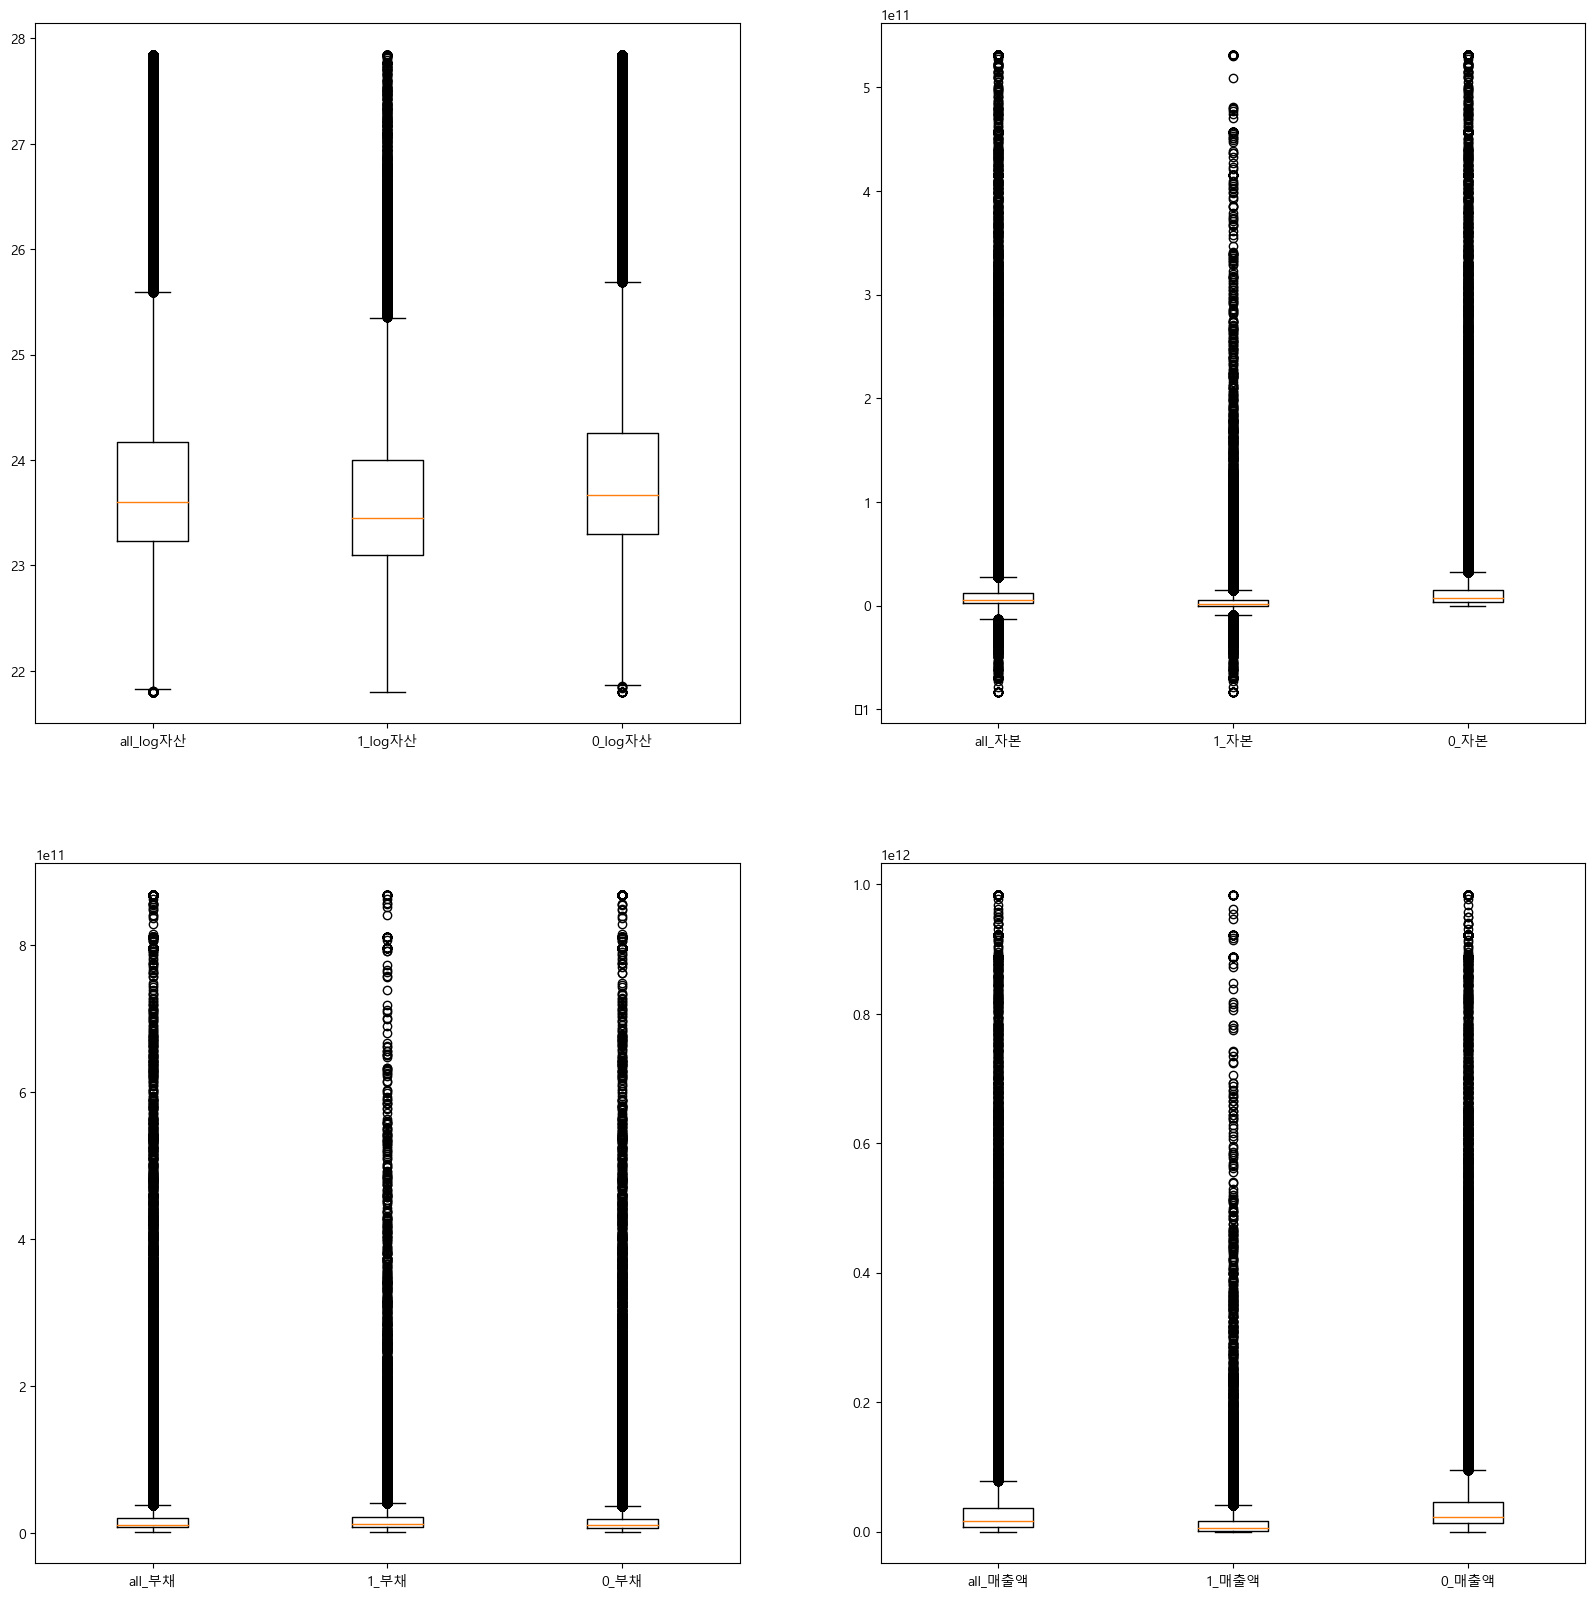

In [21]:
plt.rc('font', family = 'Malgun Gothic')
plt.figure(figsize=[20, 20])
plt.subplot(2,2,1)
plt.boxplot([np.log(gaap['자산']),np.log(gaap_1['자산']), np.log(gaap_0['자산'])], labels = ['all_log자산','1_log자산', '0_log자산'])
plt.subplot(2,2,2)
plt.boxplot([gaap['자본'], gaap_1['자본'], gaap_0['자본']], labels = ['all_자본', '1_자본', '0_자본'])
plt.subplot(2,2,3)
plt.boxplot([gaap['부채'], gaap_1['부채'], gaap_0['부채']], labels = ['all_부채', '1_부채', '0_부채'])
plt.subplot(2,2,4)
plt.boxplot([gaap['매출액(영업수익)'], gaap_1['매출액(영업수익)'], gaap_0['매출액(영업수익)']], labels = ['all_매출액', '1_매출액', '0_매출액'])
plt.show()